# high frequency signal: stationary, non-stationary, autocovariance & spectra

Basic properties

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp

# print_figs = False

---

## init signal

In [2]:
u = hf.high_frequency_signal(stationary=True)
u.autocorrelation

U**2*exp(-tau/T)*cos(sigma*tau)/2 + U_s**2*cos(sigma*tau)/2

In [3]:
u.spectrum

T*U**2*(T**2*(omega**2 + sigma**2) + 1)/(T**4*(-omega**2 + sigma**2)**2 + 2*T**2*(omega**2 + sigma**2) + 1) + pi*U_s**2*(DiracDelta(-omega + sigma) + DiracDelta(omega + sigma))/2

In [4]:
u.variance

U**2/2 + U_s**2/2

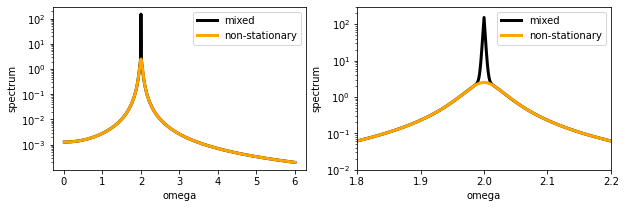

In [5]:
rad = 2 * np.pi
p = dict(U=1.0, Us=1.0, T=5.0, sigma=2.0 * rad, omega=dict(N=10000))
p_ns = dict(**p)
p_ns["Us"] = 0.0

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

ax = axes[0]

u.plot_spectrum(
    eval_kwargs=p,
    label="mixed",
    color="k",
    xscale="linear",
    ax=ax,
)
u.plot_spectrum(
    eval_kwargs=p_ns,
    label="non-stationary",
    color="orange",
    xscale="linear",
    ax=ax,
)

ax = axes[1]

u.plot_spectrum(
    eval_kwargs=p,
    label="mixed",
    color="k",
    xlim=(1.8, 2.2),
    ylim=(1e-2, 3 * 1e2),
    xscale="linear",
    ax=axes[1],
)

u.plot_spectrum(
    eval_kwargs=p_ns,
    label="non-stationary",
    color="orange",
    xscale="linear",
    ax=ax,
)

# if print_figs:
#    plt.savefig('figs/overview_lowhigh_spectrum.png')

---

## time series

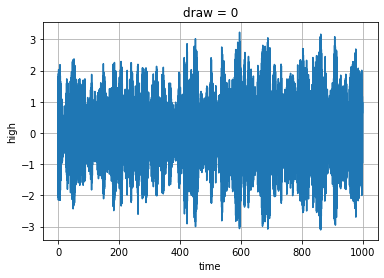

In [6]:
rad = 2 * np.pi
p = dict(U=1.0, Us=1.0, T=5.0, sigma=1.98 * rad)

u_t = u.generate_tseries(
    params=p,
    seed=0,
    time=(1000, 1 / 24),
    draws=100,
).persist()

# time=(100, 1/24/4),
# u_t.where(u_t.time<30).plot.line(x="time")
u_t.isel(draw=0).plot.line(x="time")
plt.grid()

# if print_figs:
#    plt.savefig('figs/overview_high_tseries.png')

---

## spectra

In [9]:
T = 100
E, f = sigp.spectrum_welch(u_t, T=T, return_onesided=True)

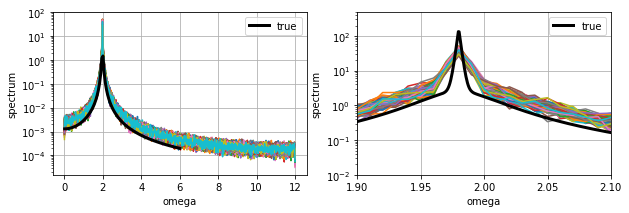

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

ax = axes[0]

E.plot.line(
    ax=ax, x="freq_time", xscale="log", yscale="log", hue="draw", add_legend=False
)

u.plot_spectrum(
    eval_kwargs=p,
    label="true",
    color="k",
    xscale="linear",
    ax=ax,
)


ax = axes[1]

E.plot.line(
    ax=ax, x="freq_time", xscale="log", yscale="log", hue="draw", add_legend=False
)

u.plot_spectrum(
    eval_kwargs=dict(**p, omega=dict(N=10000)),
    label="true",
    color="k",
    xlim=(1.9, 2.1),
    ylim=(1e-2, 5 * 1e2),
    xscale="linear",
    ax=axes[1],
)

# if print_figs:
#    plt.savefig('figs/overview_lowhigh_spectrum.png')

---

## generate spectrum of a pure tone

will be used for the fit ultimately

In [12]:
# _ds = xr.Dataset(coords=dict(sigma=("sigma", np.arange(1.9, 2.1,.0512))))
_ds = xr.Dataset(
    coords=dict(sigma=("sigma", [1.9, 1.95, 1.99, 1.999, 1.9999, 1.99999, 2.0]))
)
u_cos = np.cos(rad * _ds.sigma * u_t.time)
u_sin = np.sin(rad * _ds.sigma * u_t.time)

# u_cos.sel(time=slice(0,2)).plot()

# compute spectra
E_cos, f = sigp.spectrum_welch(u_cos, T=T, return_onesided=True)
E_cos_nowindow, f = sigp.spectrum_welch(
    u_cos, T=T, window="boxcar", return_onesided=True
)
E_sin, f = sigp.spectrum_welch(u_sin, T=T, return_onesided=True)

#### spectrum without cos function

3 frequencies captures all the signal if the signal frequency falls on the frequency line

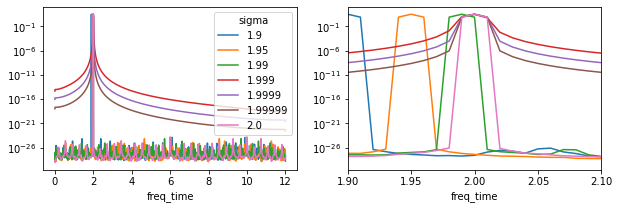

In [13]:
_E = E_cos

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax = axes[0]
_E.plot.line(
    ax=ax,
    x="freq_time",
    yscale="log",
    hue="sigma",
)
ax = axes[1]
_E.plot.line(
    ax=ax, x="freq_time", xlim=(1.9, 2.1), yscale="log", hue="sigma", add_legend=False
);

In [14]:
_E.freq_time.where((_E.freq_time > 1.9) & (_E.freq_time < 2.1), drop=True)

<xarray.DataArray 'freq_time' (freq_time: 20)>
array([1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.  ,
       2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09])
Coordinates:
  * freq_time  (freq_time) float64 1.9 1.91 1.92 1.93 ... 2.06 2.07 2.08 2.09

#### spectrum without sin function

Verifies spectra are idendical

Text(2.065, 114.29695862126357, 'df')

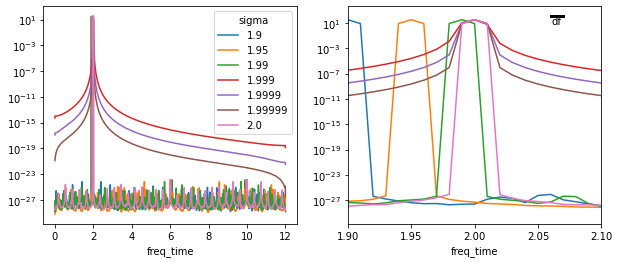

In [15]:
_E = E_sin

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
_E.plot.line(
    ax=ax,
    x="freq_time",
    yscale="log",
    hue="sigma",
)
ax = axes[1]
_E.plot.line(
    ax=ax, x="freq_time", xlim=(1.9, 2.1), yscale="log", hue="sigma", add_legend=False
)


# add reference spectral resolution
df = float(E.freq_time[1] - E.freq_time[0])  # =1/T

xlims, ylims = ax.get_xlim(), ax.get_ylim()
alpha_x, alpha_y = 0.8, 0.1
x = xlims[0] + (xlims[1] - xlims[0]) * alpha_x
y = ylims[0] + (ylims[1] - ylims[0]) * alpha_y

ax.plot([x, x + df], [y, y], color="k", lw=3)
ax.text(x + df * 0.5, y, "df", verticalalignment="top", horizontalalignment="center")

#### spectrum without windowing

Only one frequency contains energy if the signal frequency falls on the frequency line

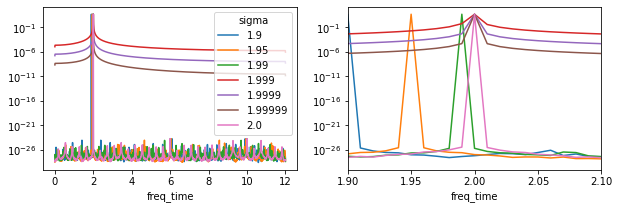

In [16]:
_E = E_cos_nowindow

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax = axes[0]
_E.plot.line(
    ax=ax,
    x="freq_time",
    yscale="log",
    hue="sigma",
)
ax = axes[1]
_E.plot.line(
    ax=ax, x="freq_time", xlim=(1.9, 2.1), yscale="log", hue="sigma", add_legend=False
);